In [ ]:
!pip install h5py==2.10.0

In [ ]:
%tensorflow_version 1.x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import skimage.transform

In [ ]:
!pip install mtcnn

In [ ]:
import mtcnn
mtcnn_model = mtcnn.MTCNN()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
facenet_model_path = '/content/drive/My Drive/Machine Learning and Neural Networks/facenet_keras.h5'
facenet_model = tf.keras.models.load_model(facenet_model_path)

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

!curl -o pixney_faces.jpeg https://i.pinimg.com/originals/cf/04/14/cf0414f971aa50c87140ed49223da33b.jpg
disneypixarfaces = cv2.imread('pixney_faces.jpeg', cv2.IMREAD_UNCHANGED)




  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 64511  100 64511    0     0   940k      0 --:--:-- --:--:-- --:--:--  940k


In [ ]:
face_path = '/content/drive/My Drive/Machine Learning and Neural Networks/faces/'
names_faces = {
    # name        :  face 
    'RajeshSharma'   : 'Rajesh1.jpg',
    'AlbertoMartin'  : 'AlbertoMartin1.jpg',
    'Donovan'        : 'Donovan1.jpg',
    'Gabriel'        : 'GabrielZ1.jpg',
    'Gerrit'         : 'Gerrit1.jpg',
    'JesusH'         : 'JesusH1.jpg',
    'JonathanM'      : 'JonathanM1.jpg',
    'LouH'           : 'LouH1.jpg',
    'MartinA'        : 'MartinA1.jpg',
    'Randi'          : 'Randi1.jpg',
    'ThanhP'         : 'ThanhP1.jpg',
    'ML'             : 'ML2.jpg',
    'SabrinaK'       : 'SabrinaK1.jpg'
}
print(names_faces)

{'RajeshSharma': 'Rajesh1.jpg', 'AlbertoMartin': 'AlbertoMartin1.jpg', 'Donovan': 'Donovan1.jpg', 'Gabriel': 'GabrielZ1.jpg', 'Gerrit': 'Gerrit1.jpg', 'JesusH': 'JesusH1.jpg', 'JonathanM': 'JonathanM1.jpg', 'LouH': 'LouH1.jpg', 'MartinA': 'MartinA1.jpg', 'Randi': 'Randi1.jpg', 'ThanhP': 'ThanhP1.jpg', 'ML': 'ML2.jpg', 'SabrinaK': 'SabrinaK1.jpg'}


In [ ]:
# show the images (these will be our ground truth)
for name, face in names_faces.items(): 
    # replace file names with actual images in the dictionary
    img = cv2.imread(face_path+face)
    # cv2 by default stores images in BGR format, store in RGB
    names_faces[name] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print('\n', name)
    cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
def whiten_image(img):
  img = img/255.0
  axis = (0, 1, 2)
  size = img.size
  mean = np.mean(img, axis=axis, keepdims=True)
  std = np.std(img, axis=axis, keepdims=True)
  std_adj = np.maximum(std, 1.0/np.sqrt(size))
  whitened_image = (img-mean)/std
  return whitened_image

In [31]:
def encode_face(img, x, y, w, h):
  #only the face part
  face_only = img[y:y+h, x:x+w, :]
  # resize to 160x160 (without stretching)
  face_only = skimage.transform.resize(face_only,(160, 160), mode='reflect')
  # normalize
  face_only = whiten_image(face_only)
  # find encoding
  encoding = facenet_model.predict(np.expand_dims(face_only, 0))
  return encoding


In [30]:
def encode_known_faces(face_dict):
    for name, face in face_dict.items():
        detected_faces = mtcnn_model.detect_faces(face)
        # extract details of the face
        for i in range(0, len(detected_faces)):
            x, y, w, h = detected_faces[i]['box']
            encoding = encode_face(face, x, y, w, h)
            # store it away
            face_dict[name] = encoding 
            #print(name, encoding)   
            break # assume only one face per image   

In [33]:
def find_closest_face(encoding):
  distances = []
  for name, face in names_faces.items():
    dist = np.linalg.norm(encoding-face)
    distances.append(dist)
  min_distance = np.min(distances)
  min_distance_name = list(names_faces)[np.argmin(distances)]
  return min_distance, min_distance_name

In [34]:
def recognize_faces(new_img):
  faces = mtcnn_model.detect_faces(new_img)
  for i in range(0, len(faces)):
      x, y, w, h = faces[i]['box']
      # compute encoding
      encoding = encode_face(new_img, x, y, w, h)
      # find the face with minimum encoding distance from this one
      dist, name = find_closest_face(encoding)
      if (dist < 11):
          print(dist, name)
          # draw rectangle and name
          cv2.rectangle(new_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
          cv2.putText(new_img, name, (x, y-3), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.75, (255, 0, 0), 2)
  return new_img


In [35]:
encode_known_faces(names_faces)

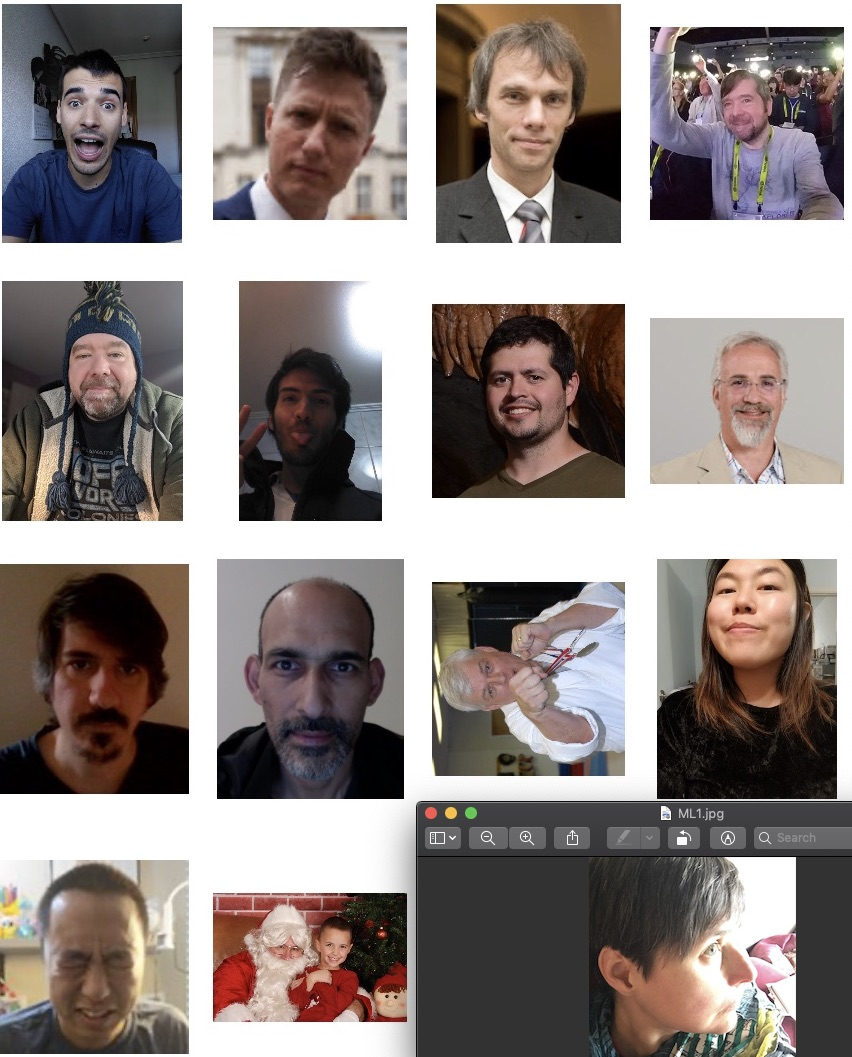

In [36]:
img = cv2.imread(face_path+'All.jpg')
cv2_imshow(img)



In [37]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
final_img = recognize_faces(img)

6.202314 JonathanM
8.246582 Donovan
7.920872 AlbertoMartin
7.1009707 RajeshSharma
10.809627 JesusH
9.733361 SabrinaK
9.188321 Gabriel
7.0403996 Gerrit
9.953714 MartinA
6.230223 LouH
7.044174 Gerrit
10.717454 ML


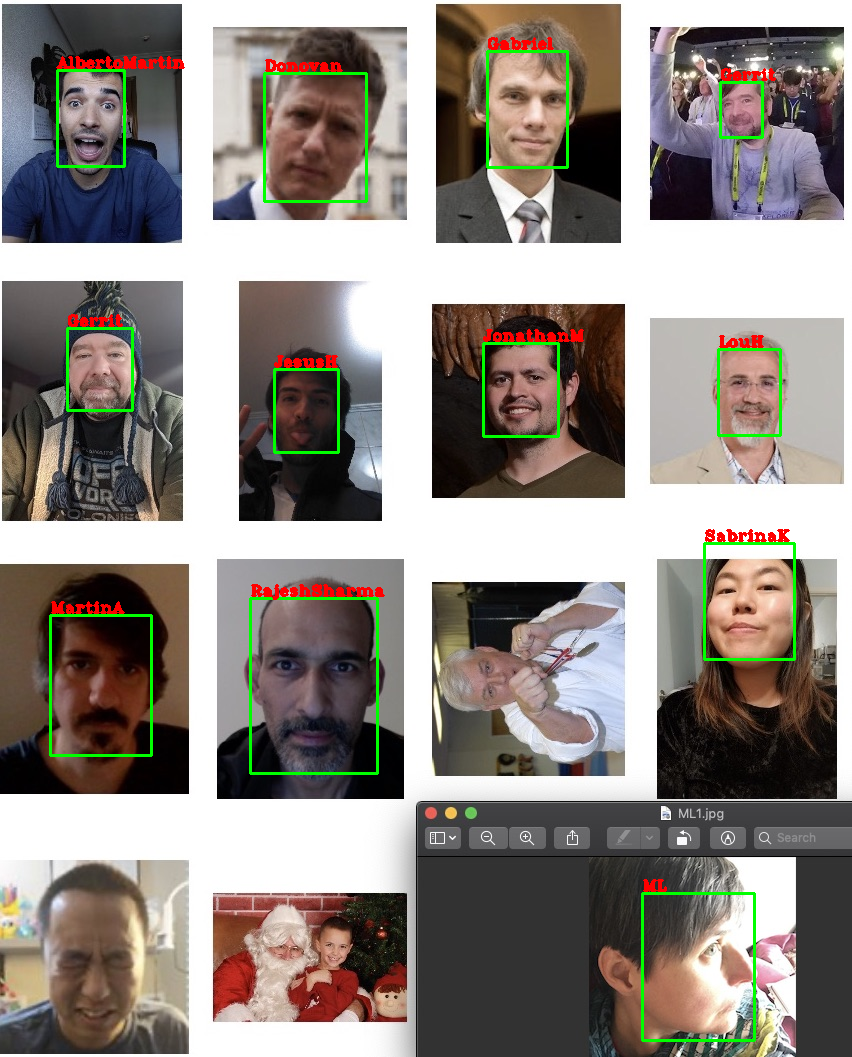

In [38]:
cv2_imshow(final_img[:,:,::-1])

In [ ]:
'''
from IPython.display import HTML
from base64 import b64encode
mp4 = open('sample.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)
'''